In [1]:
import os
import json
import pickle

import numpy as np
import polars as pl
import nibabel as nib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

from sklearn.metrics import auc, average_precision_score
from tqdm import tqdm

## Testing labels

In [2]:
plt.style.use("seaborn-v0_8-white")
plt.rcParams["legend.labelcolor"] = "white"
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.facecolor"] = "#202020"

plt.rcParams["legend.edgecolor"] = "#A0A0A0"
plt.rcParams["legend.framealpha"] = 0.85
plt.rcParams["legend.fancybox"] = True

In [3]:
ROOT_DIR = os.getcwd()  #

In [4]:
WORKSPACE_DIR = os.path.join(ROOT_DIR, "workspace")

In [5]:
IMAGE_DIR = os.path.join(WORKSPACE_DIR, "test/imagesTs")
TRUE_LABEL_DIR = os.path.join(WORKSPACE_DIR, "test/labelsTs", "true")
BASELINE_PREDICTIONS_DIR = os.path.join(WORKSPACE_DIR, "test/labelsTs/predicted")
TVERSKY_PREDICTIONS_DIR = os.path.join(WORKSPACE_DIR, "test/labelsTs/tversky_predicted")
PREDICTED_MAP_DIR = os.path.join(TVERSKY_PREDICTIONS_DIR, "pdac-detection-map")

In [6]:
PDAC_LABEL_ID = 1
LABEL_ANNOTATIONS = {
    0: "Background",
    1: "PDAC lesion",
    2: "Veins",
    3: "Arteries",
    4: "Pancreas parenchyma",
    5: "Pancreatic duct",
    6: "Common bile duct",
}

In [7]:
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

In [8]:
pdac_likelihood_json_path = os.path.join(TVERSKY_PREDICTIONS_DIR, "pdac-likelihood.json")
try:
    with open(pdac_likelihood_json_path, "r") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: PDAC likelihood JSON file not found at {pdac_likelihood_json_path}")
    data = {}

rows = [{"id": key, "pdac_likelihood": value} for key, value in data.items()]
predicted_pdac_scores_df = pl.DataFrame(
    rows,
    schema={
        "id": pl.Utf8,
        "pdac_likelihood": pl.Float64,
    },
)

In [9]:
predicted_pdac_scores_df

id,pdac_likelihood
str,f64
"""100158_00001_0000""",0.00852
"""100224_00001_0000""",0.004843
"""100460_00001_0000""",0.008798
"""100501_00001_0000""",0.004516
"""100836_00001_0000""",0.013172
…,…
"""100073_00001_0000""",0.004869
"""100459_00001_0000""",0.026821
"""100692_00001_0000""",0.004213


In [10]:

def get_image_data(image_filename: str, image_dir: str) -> np.ndarray | None:
    """
    Loads the data array from a NIfTI image file.
    """
    try:
        image_path = os.path.join(image_dir, image_filename)
        image = nib.load(image_path)
        return np.asanyarray(image.dataobj)
    except FileNotFoundError:
        print(f"Warning: Image file not found at {image_path}. Returning None.")
        return None
    except Exception as e:
        print(f"Warning: Error loading image {image_filename}: {e}. Returning None.")
        return None


def convert_label_id_to_image_id(label_filename: str, suffix: str = "_0000") -> str:
    """
    Converts a label filename to a corresponding image filename convention.
    Example: "100006_00001.nii.gz" -> "100006_00001_0000.nii.gz"
    """
    parts = label_filename.split(".", 1)
    base_name = parts[0]
    extensions = parts[1] if len(parts) > 1 else ""
    return f"{base_name}{suffix}.{extensions}" if extensions else f"{base_name}{suffix}"

In [11]:
def check_pdac_presence(label_filename: str, true_label_dir: str, pdac_label_id: int) -> bool:
    """
    Efficiently checks if a PDAC lesion is present in a NIfTI label image file.
    """
    try:
        label_image_path = os.path.join(true_label_dir, label_filename)
        label_image = nib.load(label_image_path)
        data_arr = np.asanyarray(label_image.dataobj)
        
        is_present = np.any(data_arr == pdac_label_id)
        del data_arr
        
        return is_present
        
    except FileNotFoundError:
        print(f"Warning: Label file not found at {label_image_path}. Returning False.")
        return False
    except Exception as e:
        print(f"Warning: Error processing {label_filename}: {e}. Returning False.")
        return False

In [12]:
true_label_files = os.listdir(TRUE_LABEL_DIR)

In [13]:

if true_label_files:
    example_label_filename = true_label_files[0]  # Using the first file as an example
    example_label_path = os.path.join(TRUE_LABEL_DIR, example_label_filename)
    try:
        example_label_image = nib.load(example_label_path)
        example_image_arr = np.asanyarray(example_label_image.dataobj)
        print(
            f"Shape of an example true label image ('{example_label_filename}'): {example_image_arr.shape}"
        )
    except Exception as e:
        print(f"Could not load example image '{example_label_filename}': {e}")
else:
    print("No true label files found in directory.")

Shape of an example true label image ('100786_00001.nii.gz'): (512, 512, 218)


In [14]:
PDAC_PRESENCE_PATH = os.path.join(RESULTS_DIR, "pdac_presence.pkl")

if os.path.exists(PDAC_PRESENCE_PATH):
    print(f"Loading cached PDAC presence from: {PDAC_PRESENCE_PATH}")
    with open(PDAC_PRESENCE_PATH, "rb") as f:
        pdac_presence_map = pickle.load(f)
else:
    print("Checking for PDAC presence in label files...")
    pdac_presence_map = {
        filename: check_pdac_presence(filename, TRUE_LABEL_DIR, PDAC_LABEL_ID)
        for filename in tqdm(
            true_label_files, desc="Checking label files"
        )
    }
    print(f"Saving computed PDAC presence to: {PDAC_PRESENCE_PATH}")
    with open(PDAC_PRESENCE_PATH, "wb") as f:
        pickle.dump(pdac_presence_map, f)

pdac_presence_list = list(pdac_presence_map.values())
unique_pdac_counts, counts_pdac = np.unique(pdac_presence_list, return_counts=True)
print("PDAC presence in true labels:")
for val, count in zip(unique_pdac_counts, counts_pdac):
    print(f"- {'Contains PDAC' if val else 'No PDAC'}: {count} images")

Loading cached PDAC presence from: /home/bobby/repos/PDAC_Detection_forked/results/pdac_presence.pkl
PDAC presence in true labels:
- No PDAC: 126 images
- Contains PDAC: 54 images


In [15]:
if not predicted_pdac_scores_df.is_empty():
    predicted_pdac_scores_df = predicted_pdac_scores_df.with_columns(
        (pl.col("pdac_likelihood") < 0.5)
        .cast(pl.Int8)
        .alias("predicted_below_threshold")
    )
    score_distribution = (
        predicted_pdac_scores_df.group_by(["predicted_below_threshold"])
        .agg(
            [
                pl.len().alias("count"),
            ]
        )
        .sort("predicted_below_threshold")
    )
    print("Distribution of predicted PDAC likelihoods (0: >= 0.5, 1: < 0.5):")
    print(score_distribution)
else:
    print("Predicted PDAC scores DataFrame is empty. Skipping distribution analysis.")

Distribution of predicted PDAC likelihoods (0: >= 0.5, 1: < 0.5):
shape: (1, 2)
┌───────────────────────────┬───────┐
│ predicted_below_threshold ┆ count │
│ ---                       ┆ ---   │
│ i8                        ┆ u32   │
╞═══════════════════════════╪═══════╡
│ 1                         ┆ 180   │
└───────────────────────────┴───────┘


## ROC

In [16]:
class_thresholds = np.linspace(0, 1, 100)

In [17]:
def get_cm_for_threshold(threshold: float) -> np.ndarray:
    cm = np.zeros((2, 2), dtype=int)
    for label, existance in pdac_presence_map.items():
        pdac_score = (
            predicted_pdac_scores_df.filter(pl.col("id") == label[:-7] + "_0000")
            .get_column("pdac_likelihood")
            .to_numpy()[0]
        )
        true_label = existance != np.False_
        predicted_label = pdac_score > threshold
        cm[int(true_label), int(predicted_label)] += 1

    return cm

In [ ]:
def plot_cm(threshold: float):
    cm = get_cm_for_threshold(threshold)
    fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["No PDAC", "PDAC"],
        yticklabels=["No PDAC", "PDAC"],
        ax=ax,
    )
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix at Threshold {threshold:.2f} of Tversky Model")
    plt.show()

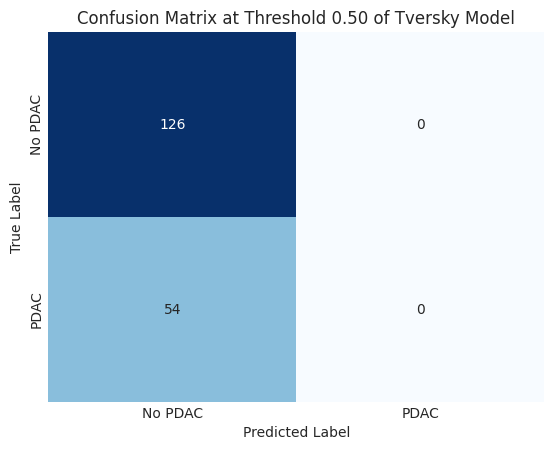

In [19]:
plot_cm(0.5)

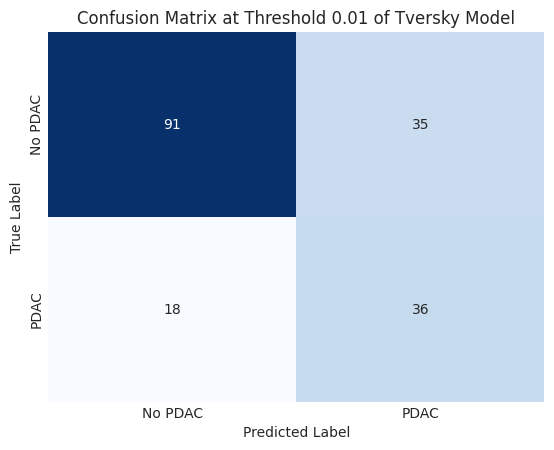

In [20]:
plot_cm(0.01)

In [21]:
def get_tpr_and_fpr(threshold: float) -> tuple:
    cm = get_cm_for_threshold(threshold)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr

In [ ]:
def plot_roc_with_auc_score():
    tpr_list = []
    fpr_list = []
    for threshold in class_thresholds:
        tpr, fpr = get_tpr_and_fpr(threshold)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc_score = auc(fpr_list, tpr_list)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_list, tpr_list, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray") 
    plt.fill_between(fpr_list, tpr_list, alpha=0.2)

    plt.text(
        0.5,
        0.2,
        f"AUC: {auc_score:.2f}",
        fontsize=12,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    plt.title("ROC Curve with AUC Score of Tversky Model")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

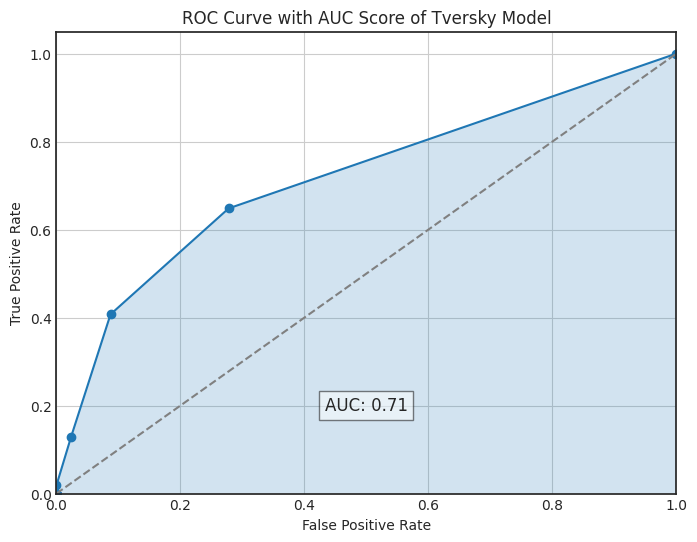

In [23]:
plot_roc_with_auc_score()

In [ ]:
# Compute average precision score from true labels and predicted likelihoods
y_true = []
y_scores = []
for label_filename, presence in pdac_presence_map.items():
    base_name = label_filename.removesuffix(".nii.gz")
    pred_id = f"{base_name}_0000"
    score_series = predicted_pdac_scores_df.filter(pl.col("id") == pred_id).select("pdac_likelihood")
    if score_series.is_empty():
        continue
    score = score_series.item()
    y_scores.append(score)
    y_true.append(int(presence))

ap_score = average_precision_score(y_true, y_scores)
print(f"Average Precision Score: {ap_score:.3f}")

Average Precision Score: 0.583


# Samples


In [ ]:
def get_slice_with_most_pdac(label_data_arr: np.ndarray, pdac_label_id: int) -> int:
    """
    Finds the index of the slice (along axis 2) with the maximum number of PDAC-labeled voxels.
    """
    if label_data_arr.ndim != 3:
        print("Warning: Expected 3D array for label data.")
        return label_data_arr.shape[2] // 2  # Default to middle slice

    pdac_counts_per_slice = np.sum(label_data_arr == pdac_label_id, axis=(0, 1))
    if np.sum(pdac_counts_per_slice) == 0: 
        return label_data_arr.shape[2] // 2  # Default to middle if no PDAC
    return int(np.argmax(pdac_counts_per_slice))

In [ ]:
def plot_multi_prediction_overlay(
    true_label_filename: str,
    image_dir: str,
    true_label_dir: str,
    baseline_pred_dir: str,
    tversky_pred_dir: str,
    pdac_label_id: int,
):
    """
    Plots the original image slice with true, baseline, and Tversky PDAC segmentations overlaid.
    """
    true_label_data = get_image_data(true_label_filename, true_label_dir)
    if true_label_data is None:
        return
    slice_idx = get_slice_with_most_pdac(true_label_data, pdac_label_id)

    image_filename = convert_label_id_to_image_id(true_label_filename)
    original_image_data = get_image_data(image_filename, image_dir)
    if original_image_data is None:
        return
    if slice_idx >= original_image_data.shape[2]:
        slice_idx = original_image_data.shape[2] // 2
    axial_image_slice = original_image_data[:, :, slice_idx].T

    predicted_map_filename = convert_label_id_to_image_id(true_label_filename)
    
    baseline_pred_data = get_image_data(predicted_map_filename, baseline_pred_dir)
    baseline_slice = None
    if baseline_pred_data is not None and slice_idx < baseline_pred_data.shape[2]:
        baseline_slice = (baseline_pred_data[:, :, slice_idx].T > 0).astype(float)

    tversky_pred_data = get_image_data(predicted_map_filename, tversky_pred_dir)
    tversky_slice = None
    if tversky_pred_data is not None and slice_idx < tversky_pred_data.shape[2]:
        tversky_slice = (tversky_pred_data[:, :, slice_idx].T > 0).astype(float) 

    true_label_slice = true_label_data[:, :, slice_idx].T
    true_pdac_mask_slice = (true_label_slice == pdac_label_id).astype(float)

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(axial_image_slice, cmap="gray", origin="lower")

    # Overlay Baseline Prediction (cyan)
    if baseline_slice is not None and np.sum(baseline_slice) > 0:
        ax.imshow(
            baseline_slice,
            cmap=ListedColormap(["none", "cyan"]),
            alpha=0.5,
            origin="lower",
        )


    # Overlay True PDAC (deeppink)
    if np.sum(true_pdac_mask_slice) > 0:
        ax.imshow(
            true_pdac_mask_slice,
            cmap=ListedColormap(["none", "deeppink"]),
            alpha=0.5,
            origin="lower",
        )

    # Overlay Tversky Prediction (yellow)
    if tversky_slice is not None and np.sum(tversky_slice) > 0:
        ax.imshow(
            tversky_slice,
            cmap=ListedColormap(["none", "yellow"]),
            alpha=0.5,
            origin="lower",
        )

    ax.set_title(f"Prediction of PDAC \nImage: {image_filename}, Slice: {slice_idx}")
    ax.axis("off")
    
    handles = [
        plt.Line2D([0], [0], color="deeppink", lw=4, alpha=0.7, label="True PDAC"),
        plt.Line2D([0], [0], color="cyan", lw=4, alpha=0.7, label="Baseline Pred."),
        plt.Line2D([0], [0], color="yellow", lw=4, alpha=0.7, label="Tversky Pred."),
    ]
    ax.legend(handles=handles, loc="upper right")

    plt.tight_layout()
    plt.show()

In [27]:
sample_to_plot = None

pdac_positive_samples = [
    fname
    for fname, dist in pdac_presence_map.items()
    if dist != np.False_
]
sample_to_plot = pdac_positive_samples[0]
print(f"\nVisualizing sample with PDAC: {sample_to_plot}")


Visualizing sample with PDAC: 101013_00001.nii.gz


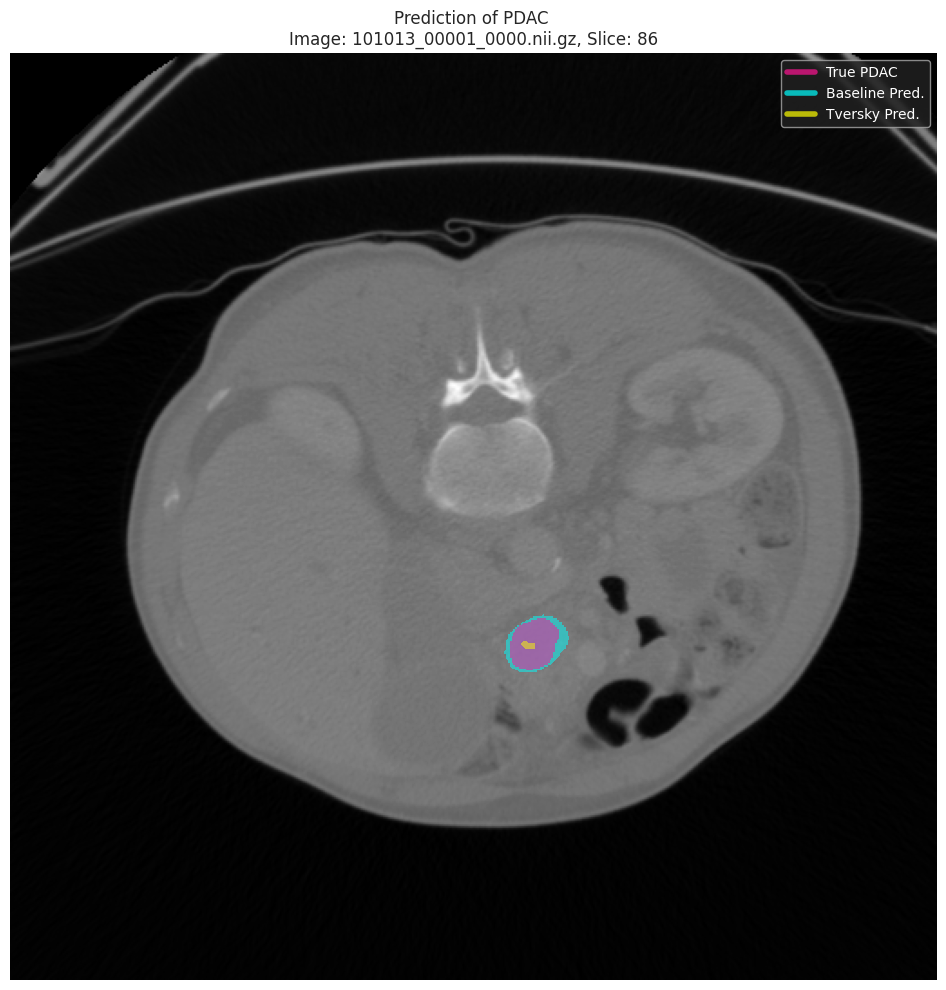

In [28]:
plot_multi_prediction_overlay(
    true_label_filename=sample_to_plot,
    image_dir=IMAGE_DIR,
    true_label_dir=TRUE_LABEL_DIR,
    baseline_pred_dir=os.path.join(BASELINE_PREDICTIONS_DIR, "pdac-detection-map"),
    tversky_pred_dir=os.path.join(TVERSKY_PREDICTIONS_DIR,  "pdac-detection-map"),
    pdac_label_id=PDAC_LABEL_ID,
)